In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.notebook import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/clim-lab/miniconda3/envs/jiwon/lib/python3.7/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352430114/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/clim-lab/miniconda3/envs/jiwon/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/clim-lab/miniconda3/envs/jiwon/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# loading training data
from torchvision import datasets
import torchvision.transforms as transforms
import os


# specify path to data
path2data = '/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

    
#load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

PermissionError: [Errno 13] Permission denied: '/data'

In [3]:
# loading training data
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = './data'

# if not exists the path, make the path
if not os.path.exists(path2data):
    os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transformer)

print(train_ds.data.shape)

Files already downloaded and verified
(5000, 3, 96, 96)


In [4]:
train_ds

Dataset STL10
    Number of datapoints: 5000
    Root location: ./data
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
import collections
y_train = [y for _,y in train_ds]
counter_train = collections.Counter(y_train)
counter_train

Counter({1: 500,
         5: 500,
         6: 500,
         3: 500,
         9: 500,
         7: 500,
         4: 500,
         8: 500,
         0: 500,
         2: 500})

In [6]:
test0_ds = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(test0_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [8]:
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())
print(len(val_ds))

Files already downloaded and verified
8000


In [9]:
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224)
])

#apply transformation
train_ds.transform = transformation
val_ds.transform = transformation

#dataloader
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)


In [10]:
train_dl

In [11]:
train_ds[5][0].shape

torch.Size([3, 224, 224])

In [12]:
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0)) #순서 바꾸기
    plt.imshow(npimg_tr)
    
    if y is not None:
        plt.title('labels : ' + str(y))

np.random.seed(10)
torch.manual_seed(0)
grid_size = 4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

In [13]:
val_ds[0][1]

6

In [14]:
train_ds[0][1]

1

In [15]:
train_ds[1]

(tensor([[[0.5059, 0.5031, 0.4947,  ..., 0.5541, 0.5591, 0.5608],
          [0.5076, 0.5045, 0.4954,  ..., 0.5570, 0.5628, 0.5647],
          [0.5126, 0.5088, 0.4976,  ..., 0.5659, 0.5738, 0.5765],
          ...,
          [0.5754, 0.5686, 0.5485,  ..., 0.6196, 0.6986, 0.7249],
          [0.5703, 0.5754, 0.5905,  ..., 0.6532, 0.7272, 0.7518],
          [0.5686, 0.5776, 0.6045,  ..., 0.6644, 0.7367, 0.7608]],
 
         [[0.5490, 0.5451, 0.5333,  ..., 0.5451, 0.5451, 0.5451],
          [0.5507, 0.5465, 0.5341,  ..., 0.5479, 0.5496, 0.5501],
          [0.5557, 0.5509, 0.5362,  ..., 0.5563, 0.5630, 0.5653],
          ...,
          [0.4840, 0.4838, 0.4831,  ..., 0.5237, 0.5847, 0.6050],
          [0.4739, 0.4836, 0.5124,  ..., 0.5561, 0.6142, 0.6336],
          [0.4706, 0.4835, 0.5221,  ..., 0.5669, 0.6241, 0.6431]],
 
         [[0.2863, 0.2835, 0.2751,  ..., 0.3204, 0.3272, 0.3294],
          [0.2896, 0.2866, 0.2775,  ..., 0.3248, 0.3325, 0.3350],
          [0.2997, 0.2960, 0.2847,  ...,

In [16]:
x_grid

[tensor([[[0.5529, 0.5524, 0.5507,  ..., 0.5529, 0.5529, 0.5529],
          [0.5524, 0.5520, 0.5508,  ..., 0.5527, 0.5525, 0.5524],
          [0.5507, 0.5508, 0.5510,  ..., 0.5520, 0.5510, 0.5507],
          ...,
          [0.5804, 0.5804, 0.5804,  ..., 0.5791, 0.5801, 0.5804],
          [0.5804, 0.5804, 0.5804,  ..., 0.5801, 0.5803, 0.5804],
          [0.5804, 0.5804, 0.5804,  ..., 0.5804, 0.5804, 0.5804]],
 
         [[0.6353, 0.6347, 0.6331,  ..., 0.6291, 0.6308, 0.6314],
          [0.6347, 0.6343, 0.6328,  ..., 0.6289, 0.6303, 0.6308],
          [0.6331, 0.6328, 0.6321,  ..., 0.6282, 0.6289, 0.6291],
          ...,
          [0.6471, 0.6471, 0.6471,  ..., 0.6458, 0.6467, 0.6471],
          [0.6471, 0.6471, 0.6471,  ..., 0.6467, 0.6470, 0.6471],
          [0.6471, 0.6471, 0.6471,  ..., 0.6471, 0.6471, 0.6471]],
 
         [[0.7569, 0.7563, 0.7546,  ..., 0.7585, 0.7602, 0.7608],
          [0.7563, 0.7558, 0.7544,  ..., 0.7583, 0.7597, 0.7602],
          [0.7546, 0.7544, 0.7537,  ...,

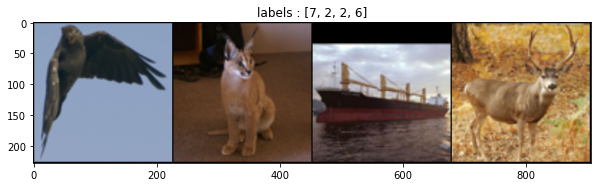

In [17]:
x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

-----

### Patch Embedding

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            
            #Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            #nn.Linear(patch_size * patch_size * in_channels, emb_size)
            
            #using conv layer instead of linear one
            nn.Conv2d(in_channels, emb_size, patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        
        
    def forward(self, x: Tensor) -> Tensor:
        x= self.projection(x)
        cls_tokens = repeat(self.cls_token, )